In [10]:
# !pip install nltk==3.9.1
# !pip cache purge
# !pip install pycaret
# !pip install pandas
# !pip install meson
# !pip install ast
# !python --version
# !pip install mlxtend==0.22.0
# !pip install matplotlib
# !pip install networkx
# !pip install seaborn

In [11]:
from pycaret import *
import pandas as pd
import ast
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import networkx as nx
import json
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import textwrap
import numpy as np

# Association rules

In [ ]:
data = pd.read_csv('dataset/Project_withPolicy.csv')
data['SecurityPolicy_content_category'] = data['SecurityPolicy_content_category'].apply(ast.literal_eval)
data = data[data['SecurityPolicy_content_category'].notna()]
data = data[['project_name', 'SecurityPolicy_content_category']]
data.head()

,project_name,SecurityPolicy_content_category
0,23andme/yamale,[Reporting mechanism]
1,9001/copyparty,[Reporting mechanism]
2,aaugustin/websockets,"[Generic policy, Scope of practice, Reporting ..."
3,adobe/ops-cli,"[Generic policy, Reporting mechanism, User gui..."
4,aio-libs/aiohttp,"[Reporting mechanism, Reporting mechanism]"


In [13]:
items = data.iloc[:, 1].dropna()
transaction_list = items.tolist()
all_items = sorted(set(item for sublist in transaction_list for item in sublist))
encoded_df = pd.DataFrame([{item: (item in transaction) for item in all_items} for transaction in transaction_list])
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1, num_itemsets=303)


In [14]:
github_template = {'Generic policy', 'Reporting mechanism', 'Scope of practise'}
template_itemsets = frequent_itemsets[
    frequent_itemsets['itemsets'].apply(lambda x: github_template.issubset(x))
]
if not template_itemsets.empty:
    template_support = template_itemsets['support'].max() 
    percentage_following_template = template_support * 100
else:
    percentage_following_template = 0
percentage_not_following_template = 100 - percentage_following_template

print(f"Percentage of repositories following GitHub's template: {percentage_following_template:.2f}%")
print(f"Percentage of repositories NOT following GitHub's template: {percentage_not_following_template:.2f}%")

Percentage of repositories following GitHub's template: 0.00%
Percentage of repositories NOT following GitHub's template: 100.00%


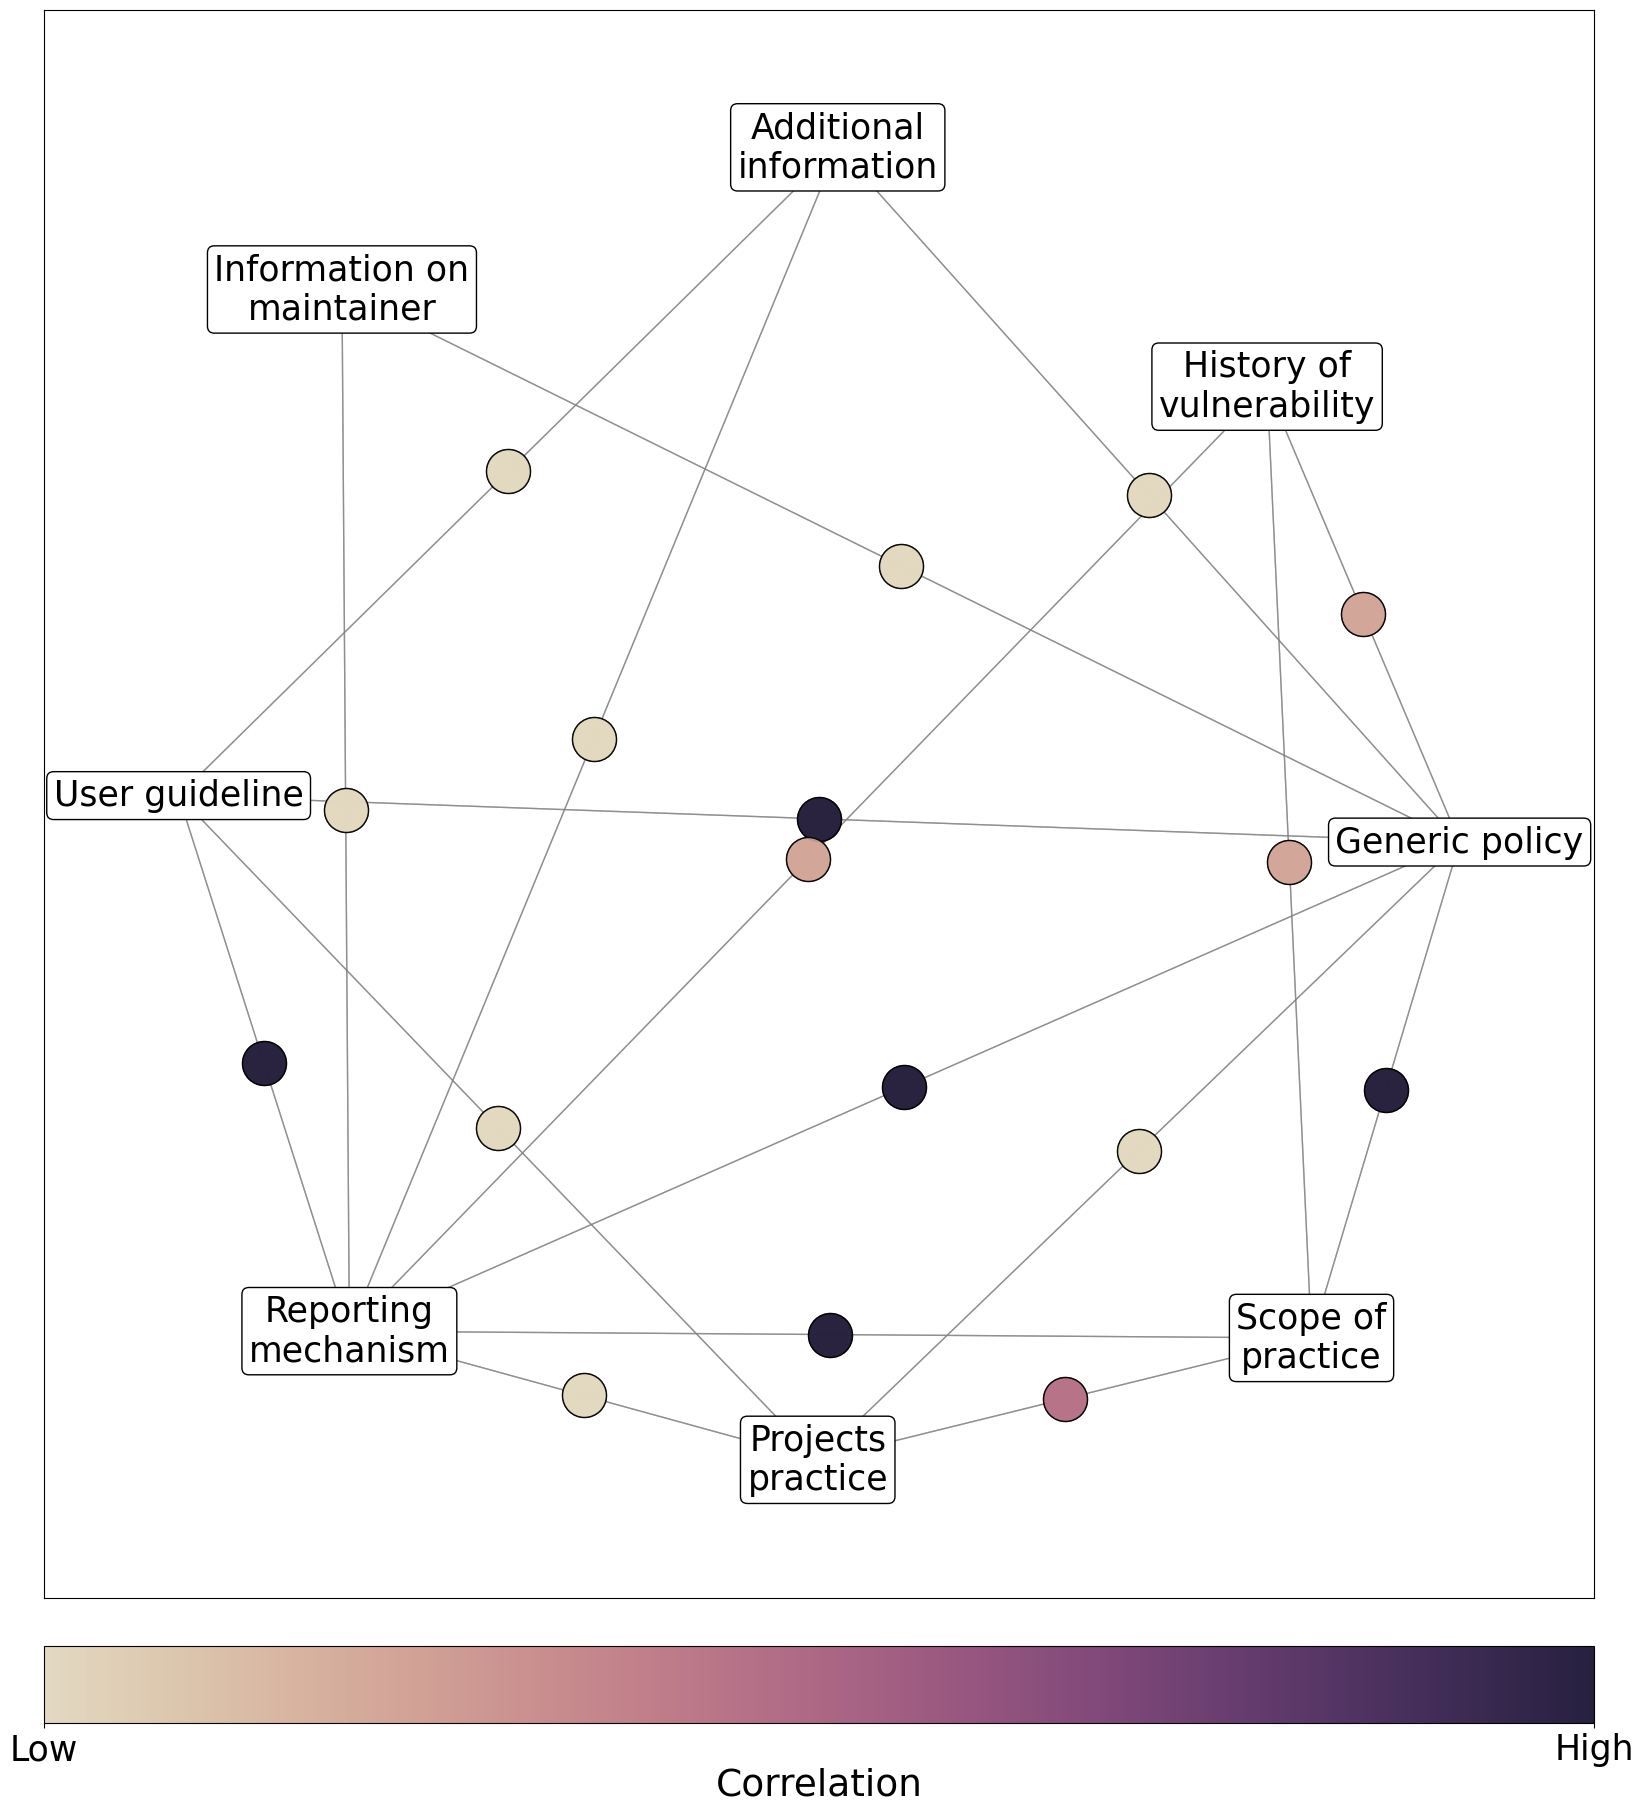

In [15]:
G = nx.DiGraph()

def wrap_label(label, max_len=15):
    return '\n'.join(textwrap.wrap(label, max_len))

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_node(antecedent)
            G.add_node(consequent)
            G.add_edge(antecedent, consequent, weight=row['support'])

support_values = [data['weight'] for _, _, data in G.edges(data=True)]
norm = Normalize(vmin=min(support_values), vmax=max(support_values))
colors = ["#440154","#718eaf", "#24a884"]
cmap = mcolors.LinearSegmentedColormap.from_list("pink", colors, N=100)
sm = ScalarMappable(norm=norm, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

wrapped_labels = {node: wrap_label(node) for node in G.nodes()}

plt.figure(figsize=(20, 25))
pos = nx.spring_layout(G, k=2, seed=42)

nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, alpha=0.65, width=1.0)

nx.draw_networkx_labels(
    G, pos, labels=wrapped_labels,
    font_size=25, font_color='black', font_weight='normal',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
)

for (u, v, data) in G.edges(data=True):
    midpoint = (pos[u] + pos[v]) / 2
    plt.scatter(*midpoint, color=sm.to_rgba((data['weight'])), s=1000, alpha=0.9, edgecolors='black')

sm.set_array(support_values)
cbar = plt.colorbar(sm, ax=plt.gca(), location="bottom", orientation="horizontal", pad=0.025)
cbar.set_label('Correlation', rotation=0, labelpad=0, size=27)

cbar.set_ticks([min(support_values), max(support_values)])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=25) 
plt.show()


# LDA

In [16]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\howto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\howto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\howto\AppData\Roaming\nltk_data...


True

In [17]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

In [ ]:
# LDA modeling for all documents
data = pd.read_csv('dataset/Content_Categories.csv')

data['processed_Document'] = data['Document'].apply(preprocess_text)
texts = data['processed_Document'].tolist()

# load dictionary
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below = 2)

# words to be procedd
total_words = sum(len(text) for text in texts)
print("Total words after preprocessing:", total_words)
unique_words = len(dictionary)
print("Unique words after filtering:", unique_words)


corpus = [dictionary.doc2bow(text) for text in texts]
# train LDA model
num_topics=6
lda_model = LdaModel(corpus=corpus, id2word=dictionary, chunksize=20, num_topics=num_topics, passes=100, iterations=200, random_state=63, eta=0.5)

for topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(topic)
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print('Coherence Score:', coherence_score)

Total words after preprocessing: 23372
Unique words after filtering: 1606
(0, '0.050*"issue" + 0.028*"report" + 0.026*"advisory" + 0.018*"fix" + 0.017*"maintainer" + 0.017*"github" + 0.014*"project" + 0.013*"cve" + 0.013*"may" + 0.013*"click"')
(1, '0.023*"model" + 0.016*"data" + 0.015*"code" + 0.014*"using" + 0.011*"pytorch" + 0.011*"untrusted" + 0.008*"run" + 0.007*"build" + 0.007*"developer" + 0.007*"secure"')
(2, '0.037*"issue" + 0.023*"please" + 0.017*"key" + 0.015*"report" + 0.014*"code" + 0.012*"source" + 0.012*"bounty" + 0.011*"possible" + 0.011*"pgp" + 0.011*"program"')
(3, '0.121*"version" + 0.084*"supported" + 0.076*"policy" + 0.040*"release" + 0.028*"whitecheckmark" + 0.023*"latest" + 0.020*"update" + 0.017*"support" + 0.013*"project" + 0.012*"currently"')
(4, '0.019*"spark" + 0.016*"file" + 0.013*"access" + 0.012*"application" + 0.012*"user" + 0.011*"tdtd" + 0.010*"secret" + 0.008*"authentication" + 0.008*"table" + 0.008*"license"')
(5, '0.086*"vulnerability" + 0.044*"repo